# Wind Turbine Object

For a given wind turbine type and effective wind speed (WS<sub>eff</sub>), the `WindTurbine` object provides the power and thrust coefficient (CT), as well as the wind turbine hub height (H) and diameter (D).

**Install PyWake if needed**

In [1]:
# Install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

### Setting up Windturbine objects

**Predefined WindTurbines example**

PyWake contains a few predefined turbines, e.g. the V80 from Hornsrev1, the 3.35MW from IEA task 37 and the DTU10MW reference turbine.

**First we import basic Python elements**

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

**Now we import the wind turbines available in PyWake**

In [3]:
from py_wake.wind_turbines import WindTurbine, WindTurbines
from py_wake.examples.data.hornsrev1 import V80
from py_wake.examples.data.iea37 import IEA37_WindTurbines, IEA37Site
from py_wake.examples.data.dtu10mw import DTU10MW

v80 = V80()
iea37 = IEA37_WindTurbines()
dtu10mw = DTU10MW()

**You can also import wind turbine files from WAsP .wtg files**

In [4]:
from py_wake.examples.data import wtg_path

wtg_file = os.path.join(wtg_path, 'NEG-Micon-2750.wtg')
neg2750 = WindTurbine.from_WAsP_wtg(wtg_file)

**In addition, user-defined WindTurbine objects is also supported by PyWake**

Here it is necessary to specify the thrust coefficient (CT) and power curve of the wind turbine you want to create. The hub height and diameter are also parameters that must be specified.

In [10]:
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular

u = [0,3,12,25,30]
ct = [0,0.8,0.9,.3, 0]
power = [0,750,2000,1800,0]

my_wt = WindTurbine(name='MyWT',
                    diameter=100,
                    hub_height=300,
                    powerCtFunction=PowerCtTabular(u,power,'kW',ct))

PyWake has a `GenericWindTurbine` class which make a wind turbine where the power is computed by an analytical model based on diameter and nominal power.

The model takes a lot of optional inputs which default to empirical values, e.g.

- **air_density**= 1.225 kg/m$^3$
- **max_cp**= .49
- **constant_ct**= .8
- **gear_loss_const**= .01
- **gear_loss_var**= .014
- **generator_loss**= 0.03
- **converter_loss**= .03

In [6]:
from py_wake.wind_turbines.generic_wind_turbines import GenericWindTurbine

#for a diameter of 178.3m and hub height of 119m
gen_wt = GenericWindTurbine('G10MW', 178.3, 119, power_norm=10000, turbulence_intensity=.1)

**Multi-type Wind Turbines**

You can collect a list of different turbine types into a single WindTurbines object

In [7]:
wts = WindTurbines.from_WindTurbine_lst([v80,iea37,dtu10mw,my_wt,gen_wt,neg2750])

In [8]:
types = wts.types()
print ("Name:\t\t%s" % "\t".join(wts.name(types)))
print('Diameter[m]\t%s' % "\t".join(map(str,wts.diameter(type=types))))
print('Hubheigt[m]\t%s' % "\t".join(map(str,wts.hub_height(type=types))))

Name:		V80	3.35MW	DTU10MW	MyWT	G10MW	NEG-Micon 2750/92 (2750 kW)
Diameter[m]	80.0	130.0	178.3	123.0	178.3	92.0
Hubheigt[m]	70.0	110.0	119.0	321.0	119.0	70.0


### Power curves and CT curves

**We plot first the power curve of the all turbines previously defined**

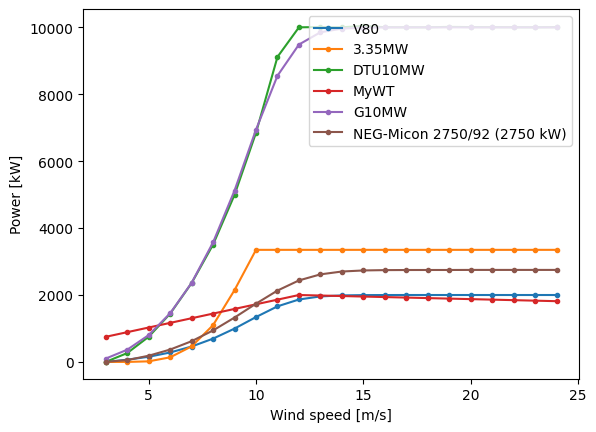

In [11]:
ws = np.arange(3,25)
plt.xlabel('Wind speed [m/s]')
plt.ylabel('Power [kW]')

for t in types:
    plt.plot(ws, wts.power(ws, type=t)*1e-3,'.-', label=wts.name(t))
plt.legend(loc=1)

**Now, we do the same for the CT curve of all turbines**

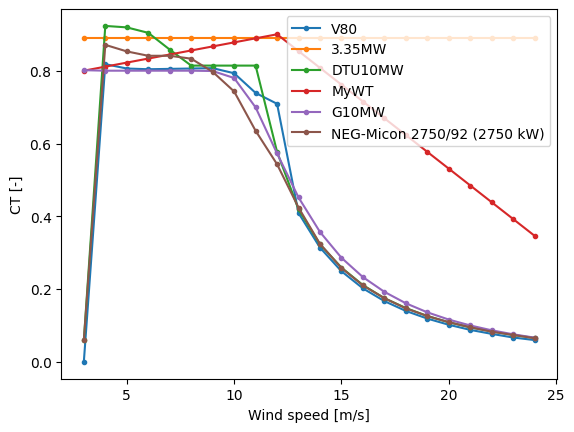

In [12]:
plt.xlabel('Wind speed [m/s]')
plt.ylabel('CT [-]')

for t in types:
    plt.plot(ws, wts.ct(ws, type=t),'.-', label=wts.name(t))
plt.legend(loc=1)

**You can also plot Multidimensional Power/CT curves**

Some WAsP wtg files define multiple wind turbine modes. E.g. the `Vestas V112-3.0 MW.wtg` which has 12 modes representing different levels of air density. In this case, the mode defaults to 0.

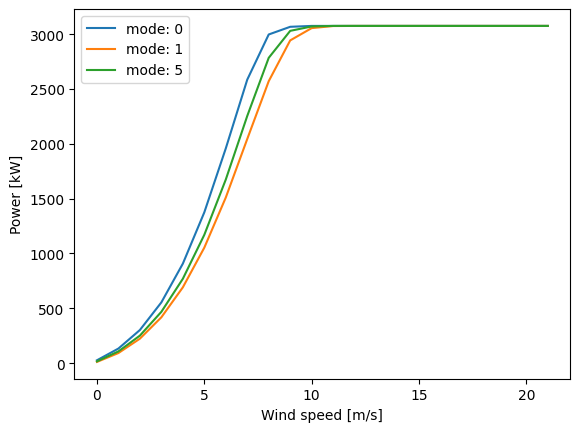

In [13]:
wtg_file = os.path.join(wtg_path, 'Vestas V112-3.0 MW.wtg')
v112 = WindTurbine.from_WAsP_wtg(wtg_file)
required_inputs, optional_inputs = v112.function_inputs
upct = {}

#selecting the modes to plot
for m in [0,1,5]:
    plt.plot(v112.power(ws, mode=m)/1000, label=f'mode: {m}')

p0,ct0 = v112.power_ct(ws, mode=0)
p1,ct1 = v112.power_ct(ws, mode=1)

plt.ylabel('Power [kW]')
plt.xlabel('Wind speed [m/s]')
plt.legend()

**Discrete dimensions (e.g. operational mode)**

WindTurbines can be defined using a `PowerCtFunctionList`. In fact this is the approach used by multi-mode WAsP wind turbines and also when creating multi-type wind turbine (in which case the key is `type`).

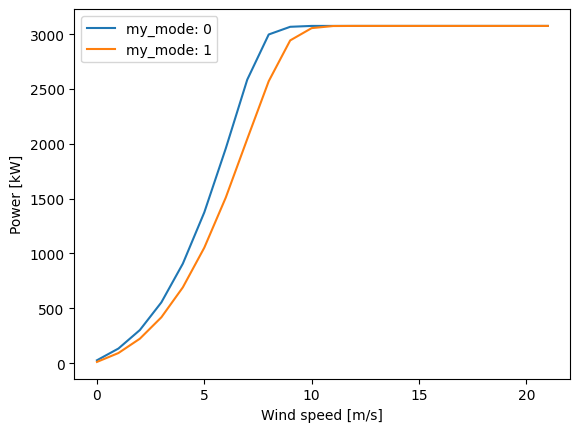

In [20]:
from py_wake.wind_turbines.power_ct_functions import PowerCtFunctionList

mode0_power_ct=PowerCtTabular(ws, p0, 'w', ct0)
mode1_power_ct=PowerCtTabular(ws, p1, 'w', ct1)

multimode_power_ct = PowerCtFunctionList(key='my_mode', 
                                         powerCtFunction_lst=[mode0_power_ct, mode1_power_ct], 
                                         default_value=None)

#specifying a diameter of 112m and hub height of 84m
wt = WindTurbine('MultimodeWT', 112, 84, powerCtFunction=multimode_power_ct)

for m in [0,1]:
    plt.plot(wt.power(ws, my_mode=m)/1000, label=f'my_mode: {m}')
plt.ylabel('Power [kW]')
plt.xlabel('Wind speed [m/s]')
plt.legend()

**It is also possible to setup a wind turbine using a multidimensional power and CT tabular array.**

In this case, the power and CT values will be calculated using multidimensional linear interpolation.

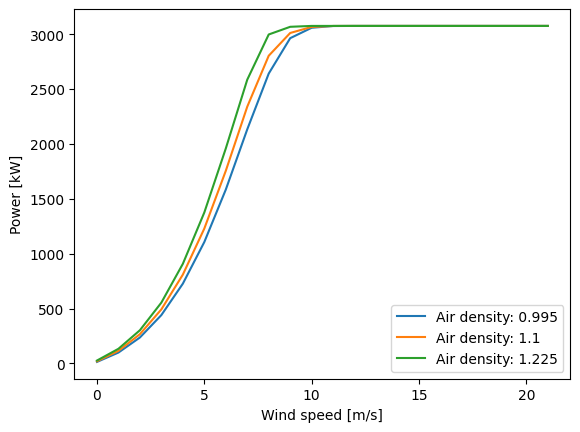

In [21]:
from py_wake.wind_turbines.power_ct_functions import PowerCtNDTabular

# setup multidimensional power and ct tabulars
# p0,ct0 ~ rho=0.95
# p1,ct1 ~ rho=1.225

power_array = np.array([p1,p0]).T
ct_array = np.array([ct1,ct0]).T
density = [0.95,1.225]

powerCtFunction = PowerCtNDTabular(input_keys=['ws','rho'], 
                 value_lst=[ws,density], 
                 power_arr=power_array, power_unit='w',
                 ct_arr=ct_array)

#specifying a diameter of 112m and hub height of 84m
wt = WindTurbine('AirDensityDependentWT', 112, 84, powerCtFunction=powerCtFunction)

#looping through different values for air density
for r in [0.995, 1.1, 1.225]:
    plt.plot(wt.power(ws, rho=r)/1000, label=f'Air density: {r}')
plt.ylabel('Power [kW]')
plt.xlabel('Wind speed [m/s]')
plt.legend()

**Alternatively, the data can be passed as an xarray dataset.**

The dataset must have the data variables, `power` and `ct`, and the coordinate, `ws`.

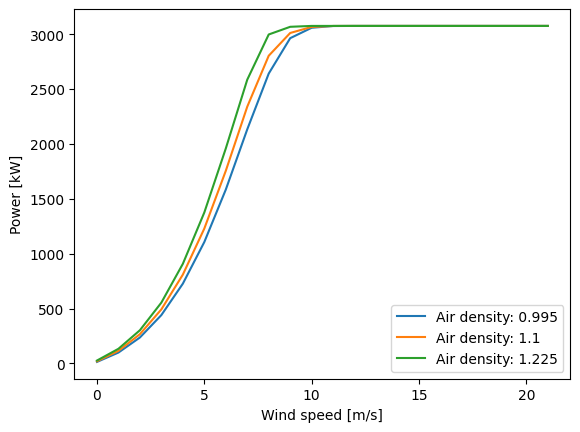

In [22]:
import xarray as xr
from py_wake.wind_turbines.power_ct_functions import PowerCtXr

ds = xr.Dataset(
        data_vars={'power': (['ws', 'rho'], np.array([p1,p0]).T),
                   'ct': (['ws', 'boost'], np.array([ct1, ct0]).T)},
        coords={'rho': [0.95,1.225], 'ws': ws})

curve = PowerCtXr(ds, 'w')

#specifying a diameter of 112m and hub height of 84m
wt = WindTurbine('AirDensityDependentWT', 112, 84, powerCtFunction=powerCtFunction)

#looping through different values of air density
for r in [0.995, 1.1, 1.225]:
    plt.plot(wt.power(ws, rho=r)/1000, label=f'Air density: {r}')
plt.ylabel('Power [kW]')
plt.xlabel('Wind speed [m/s]')
plt.legend()

**Finally, the Power and CT values can be calculated using a function which may take multiple input variables.**

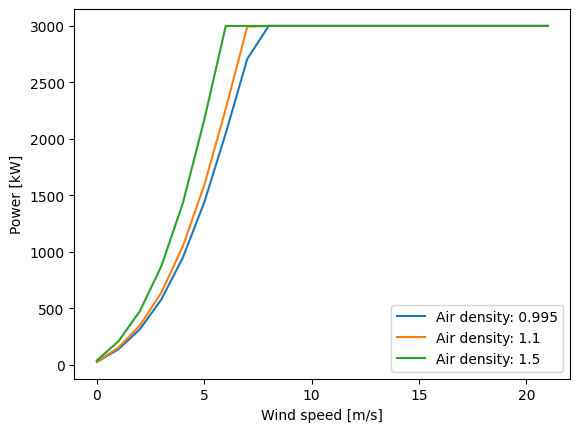

In [23]:
from py_wake.wind_turbines.power_ct_functions import PowerCtFunction

def density_scaled_power_ct(u, run_only, rho=1.225):
    # function to calculate power and ct
    if run_only==0: # power
        rated_power = 3e6
        density_scale=rho/.95
        return np.minimum(np.interp(u,ws, p0) * density_scale, rated_power) # density scaled power, limited by rated power
    elif run_only==1: #ct
        return 0*u # dummy ct, not used in this example
               
powerCtFunction = PowerCtFunction(
    input_keys=['ws','rho'], 
    power_ct_func=density_scaled_power_ct,
    power_unit='w', 
    optional_inputs=['rho'], # allowed to be optional as a default value is speficifyed in density_scaled_power_ct
)

#specifying a diameter of 112m and hub height of 84m
wt = WindTurbine('AirDensityDependentWT', 112, 84, powerCtFunction=powerCtFunction)

#looping through different values for air density
for r in [0.995, 1.1, 1.5]:
    plt.plot(wt.power(ws, rho=r)/1000, label=f'Air density: {r}')
plt.ylabel('Power [kW]')
plt.xlabel('Wind speed [m/s]')
plt.legend()

You can also use the `GenericTIRhoWindTurbine` class, which extends the `GenericWindTurbine` with multidimensional power/CT curves that depend on turbulence intensity (`TI_eff`) and the air density (`Air_density`).

Text(0.5, 0, 'Wind speed [m/s]')

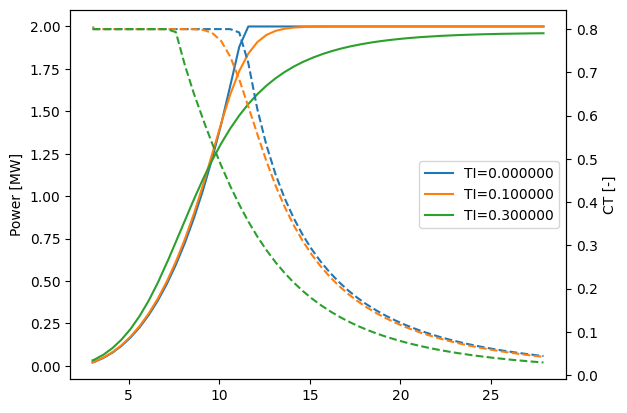

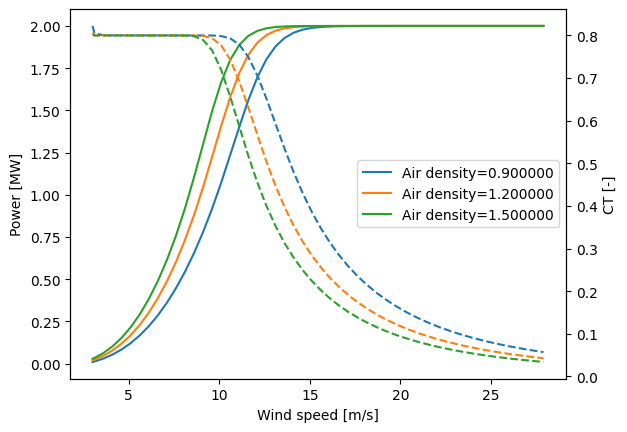

In [24]:
from py_wake.wind_turbines.generic_wind_turbines import GenericTIRhoWindTurbine

#specifying a diameter of 80m and hub height of 70m for different turbulence intensities
wt = GenericTIRhoWindTurbine('2MW', 80, 70, power_norm=2000,
                             TI_eff_lst=np.linspace(0, .5, 6), default_TI_eff=.1,
                             Air_density_lst=np.linspace(.9, 1.5, 5), default_Air_density=1.225)

u = np.arange(3, 28, .1)
ax1 = plt.gca()
ax2 = plt.twinx()

#looping through different values of turbulence intensity
for ti in [0, .1, .3]:
    p, ct = wt.power_ct(u, TI_eff=ti)
    ax1.plot(u, p / 1e6, label='TI=%f' % ti)
    ax2.plot(u, ct, '--')
ax1.legend(loc='center right')
ax1.set_ylabel('Power [MW]')
ax2.set_ylabel('CT [-]')

plt.figure()
u = np.arange(3, 28, .1)
ax1 = plt.gca()
ax2 = plt.twinx()

#looping through different values of air density
for rho in [.9,1.2,1.5]:
    p, ct = wt.power_ct(u, Air_density=rho)
    ax1.plot(u, p / 1e6, label='Air density=%f' % rho)
    ax2.plot(u, ct, '--')
ax1.legend(loc='center right')
ax1.set_ylabel('Power [MW]')
ax2.set_ylabel('CT [-]')
ax1.set_xlabel('Wind speed [m/s]')

### Power/CT input arguments
The input arguments for the Power and CT curves can be obtained from:

- Arguments passed when calling the `WindFarmModel`
- Data present in the `Site`- object
- Values computed in the simulation, i.e. `WS_eff` and `TI_eff`. Note that `WS_eff` is passed as `ws`

**1) Arguments passed to** `WindFarmModel` **call**

/home/zqc/anaconda3/envs/pywake/lib/python3.12/site-packages/py_wake/deficit_models/noj.py:88: UserWarning: The NOJ model is not representative of the setup used in the literature. For this, use py_wake.literature.noj.Jensen_1983 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.noj.Jensen_1983')


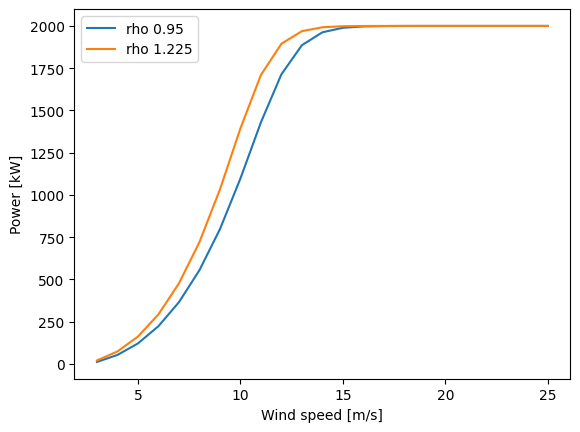

In [25]:
from py_wake.examples.data.hornsrev1 import Hornsrev1Site
from py_wake.deficit_models.noj import NOJ

wfm = NOJ(site=Hornsrev1Site(), windTurbines=wt)

for rho in [0.95,1.225]:
    sim_res = wfm([0], [0], wd=0, Air_density=rho) # rho passed to WindFarmModel call
    power = sim_res.Power.squeeze() / 1000
    plt.plot(power.ws, power, label=f'rho {rho}')
plt.xlabel('Wind speed [m/s]')
plt.ylabel('Power [kW]')
plt.legend()

**2) Data present in** `Site`

/home/zqc/anaconda3/envs/pywake/lib/python3.12/site-packages/py_wake/deficit_models/noj.py:88: UserWarning: The NOJ model is not representative of the setup used in the literature. For this, use py_wake.literature.noj.Jensen_1983 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.noj.Jensen_1983')


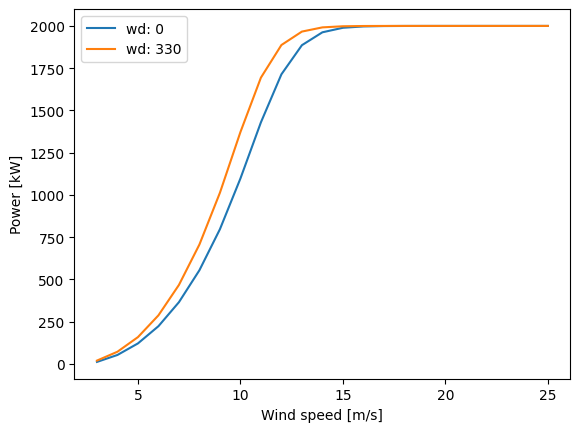

In [26]:
from py_wake.examples.data.hornsrev1 import Hornsrev1Site
from py_wake.deficit_models.noj import NOJ

site = Hornsrev1Site()
site.ds['Air_density'] = ('wd',np.linspace(.95,1.225,13)) # wd-dependent rho added to site

wfm = NOJ(site=site, windTurbines=wt)

for wd in [0,330]:
    sim_res = wfm([0], [0], wd=wd)
    power = sim_res.Power.squeeze() / 1000
    plt.plot(power.ws, power, label=f'wd: {wd}')
plt.xlabel('Wind speed [m/s]')
plt.ylabel('Power [kW]')
plt.legend()

### Interpolation method

`PowerCtTabular` **which is used by most predefined wind turbines takes a** `method` **argument which can be:**

- `linear`: Linear interpolation (default)
- `pchip`: Piecewise Cubic Hermite Interpolating Polynomial. Smooth interpolation with continous first order derivatives and not overshoots
- `spline`: Smooth interpolation with continous first and second order derivatives. Closer to original piecewise linear curve, but may have overshoots

When using the N-dimensional `PowerCtNDTabular`, only linear interpolation is supported.

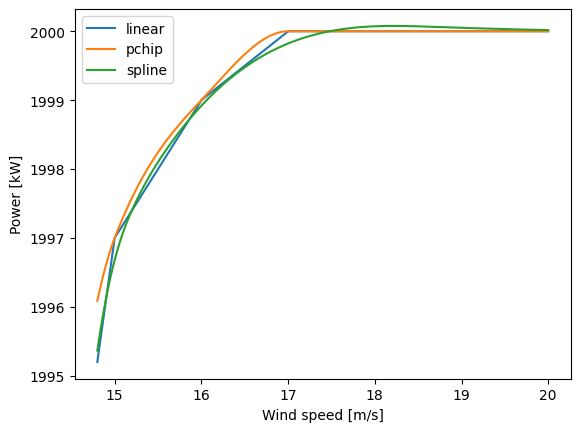

In [27]:
wt_lst = [(m, V80(method=m)) for m in ['linear','pchip','spline']]

_ws = np.linspace(14.8,20,1000)

for n, _wt in wt_lst:
    plt.plot(_ws, _wt.power(_ws)/1e3, label=n)
plt.ylabel('Power [kW]')
plt.xlabel('Wind speed [m/s]')
plt.legend()

### Plotting the wind turbines

**Top-view plot**

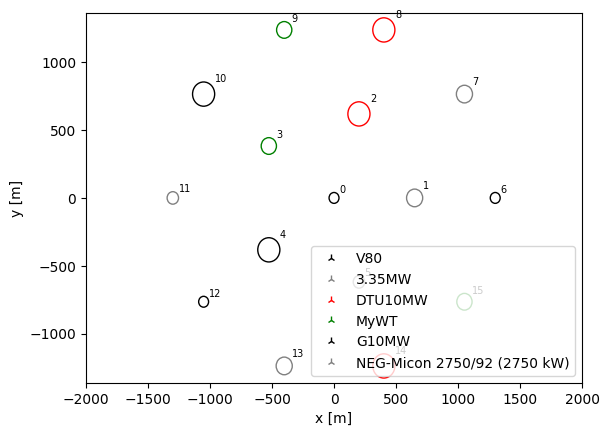

In [28]:
s = IEA37Site(16)
x,y = s.initial_position.T

plt.figure()
wts.plot_xy(x,y,types=np.arange(len(x))%len(types))
plt.xlim(-2000,2000)
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.legend()

**Side-view plot**

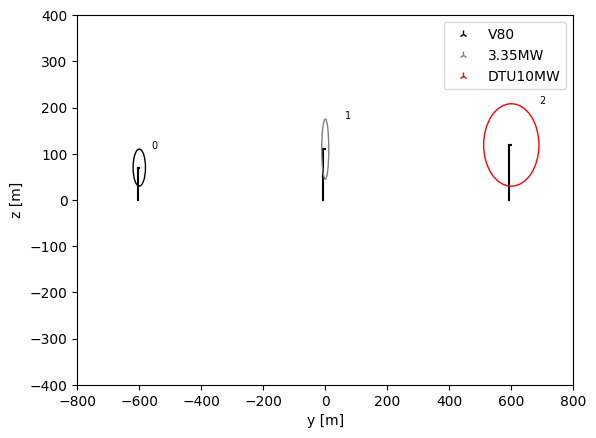

In [29]:
#here you can also specify yaw angles for the turbines
plt.figure()
wts.plot_yz(np.array([-600,0,600]), wd=0, types=[0,1,2], yaw=[-30, 10, 90])
plt.ylim(-400,400)
plt.xlim(-800,800)
plt.xlabel('y [m]')
plt.ylabel('z [m]')
plt.legend()